# Data I/O
Here we will discuss a few strategies at data access. We will investigate two approaches, one using DataFrames, and another using the HDF5 file format.

## HDF5

The Hierarchical Data Format v.5 (HDF5) is a format for large data storage which, as the name implies, allows for hierarchical field of data. HDF5 offers us an "easy" way to save and access experimental data in a portable way, as HDF5 is an open standard and has been implemented in Java, Matlab, Mathematica, Python, R, and of course for our purposes, Julia. This is in contrast to, for example, the Matlab-specific `.mat` file format. While other open approaches, such as pickling (Python), XML, or even raw CSV dumps, can be used, these methods don't scale well to the storage of large sets of diverse data. 


In [ ]:
# Grab the HDF5 package if you don't have it already.
Pkg.add("HDF5")
Pkg.build("HDF5")

In [1]:
# Use this package
using HDF5

Now, lets construct a dataset. Lets say that we have a stochastic experiment, and we need to run this experiment and store the results for further analysis. 

In [2]:
"""
run_experiment_foo(;freq = 1.0, sigma = 0.2, N = 1000)

# Description
Run our fake experiment.
"""
function run_experiment_foo(;freq = 1.0, sigma = 0.2, N = 1000)
    if N > 2000
        error("Whoa! We encountered an arbitrary bug in our experiment!")
    end
    y = [sin(freq*i) for i in linspace(0,2*pi,N)]
    z = y + sigma*randn(size(y))
    timeStamp = now()
    return y, z, timeStamp
end

run_experiment_foo (generic function with 1 method)

In [3]:
# Set some parameters on your experiment
numTrials = 5

# We will run four different experiments with four different settings
freqs  = [0.2, 0.5,1.0,2.0]
sigmas = [0.01,0.5,0.2,1.0]

# Some names for our different experiments
expNames = ["experimentA","experimentB", "experimentC", "experimentD"]

# Construct a set of parameters for our experiments
params = Dict()
params[expNames[1]] = Dict("freq" => 0.2, "sigma" => 0.01, "N" => 50)
params[expNames[2]] = Dict("freq" => 0.5, "sigma" => 0.50, "N" => 100)
params[expNames[3]] = Dict("freq" => 1.0, "sigma" => 0.20, "N" => 1000)
params[expNames[4]] = Dict("freq" => 2.0, "sigma" => 1.00, "N" => 5000)

# Run the different experiments
for exp in expNames
    for trial in 1:numTrials
        groundTruth, noisy, timeStamp = run_experiment_foo(freq  = params[exp]["freq"],
                                                           sigma = params[exp]["sigma"], 
                                                           N = params[exp]["N"])
    end    
end

LoadError: LoadError: Whoa! We encountered an arbitrary bug in our experiment!
while loading In[3], in expression starting on line 19

So, now we have our experimental framework, but where is our result data? We could store it in an array at each loop, but then what happens if our execution terminates, or we encounter a bug like the one we see above? We could potentially lose all of our data if, for example, our Julia session crashes, the computer is turned off, water starts coming from the ENS ceiling, etc. So a better pipeline would be to save our data as we go. Lets use HDF5 to accomplish that.

In [31]:
# Some arbitrary file
h5FileName = "testExperiment.h5"

# Run the different experiments
for exp in expNames
    h5write(h5FileName, string(exp,"/params/freq"), [params[exp]["freq"]])
    h5write(h5FileName, string(exp,"/params/sigma"), [params[exp]["sigma"]])
        h5write(h5FileName, string(exp,"/params/N"), [params[exp]["N"]])
    for trial in 1:numTrials
        trueData, noisyData, timeStamp = run_experiment_foo(freq  = params[exp]["freq"],
                                                           sigma = params[exp]["sigma"], 
                                                           N = params[exp]["N"])
        # For clarity, construct the prefix
        h5TrialDataPath = string(exp,"/trial",trial,"/")
        println("Writing to group [$h5TrialDataPath]")
        
        # Write data to HDF5
        h5write(h5FileName, string(h5TrialDataPath,"trueData"), trueData)
        h5write(h5FileName, string(h5TrialDataPath,"noisyData"), noisyData)
        h5write(h5FileName, string(h5TrialDataPath,"timeStamp"), string(timeStamp))
    end    
end

Writing to group [experimentA/trial1/]
Writing to group [experimentA/trial2/]
Writing to group [experimentA/trial3/]
Writing to group [experimentA/trial4/]
Writing to group [experimentA/trial5/]
Writing to group [experimentB/trial1/]
Writing to group [experimentB/trial2/]
Writing to group [experimentB/trial3/]
Writing to group [experimentB/trial4/]
Writing to group [experimentB/trial5/]
Writing to group [experimentC/trial1/]
Writing to group [experimentC/trial2/]
Writing to group [experimentC/trial3/]
Writing to group [experimentC/trial4/]
Writing to group [experimentC/trial5/]


LoadError: LoadError: Whoa! We encountered an arbitrary bug in our experiment!
while loading In[31], in expression starting on line 5

And there we go! We now have all of our experimental data stored in an HDF5 file for later perusal. For example, lets say that we wanted to take a look at the results of the first experiment.

In [32]:
expA = h5read(h5FileName,expNames[1])

Dict{ByteString,Any} with 6 entries:
  "trial3" => Dict{ByteString,Any}("trueData"=>[0.0,0.0256428,0.0512688,0.07686…
  "trial2" => Dict{ByteString,Any}("trueData"=>[0.0,0.0256428,0.0512688,0.07686…
  "trial4" => Dict{ByteString,Any}("trueData"=>[0.0,0.0256428,0.0512688,0.07686…
  "trial1" => Dict{ByteString,Any}("trueData"=>[0.0,0.0256428,0.0512688,0.07686…
  "params" => Dict{ByteString,Any}("sigma"=>[0.01],"N"=>[50],"freq"=>[0.2])
  "trial5" => Dict{ByteString,Any}("trueData"=>[0.0,0.0256428,0.0512688,0.07686…

In [33]:
# What conditions did we run this experiment under?
expA["params"]

Dict{ByteString,Any} with 3 entries:
  "sigma" => [0.01]
  "N"     => [50]
  "freq"  => [0.2]

Lets say we want to do a visualization of our dataset...

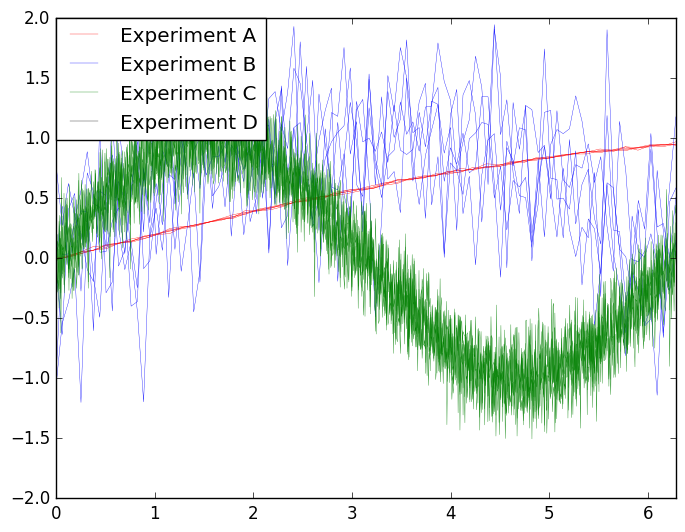

PyObject <matplotlib.legend.Legend object at 0x322b44390>

In [86]:
using PyPlot
res = h5read(h5FileName,"/")
colors = Dict("experimentA" => "r", "experimentB" => "b", "experimentC" => "g", "experimentD" => "k")
hold("on")

lsA = plot([],[],color = colors["experimentA"],lw = 0.25, label = "Experiment A")
lsB = plot([],[],color = colors["experimentB"],lw = 0.25, label = "Experiment B")
lsC = plot([],[],color = colors["experimentC"],lw = 0.25, label = "Experiment C")
lsD = plot([],[],color = colors["experimentD"],lw = 0.25, label = "Experiment D")

for exp in keys(res)
    N = res[exp]["params"]["N"][1]
    xDom = linspace(0,2*pi,N)
    for trial in keys(res[exp])
        if trial!="params"
            plot(xDom,res[exp][trial]["noisyData"],color = colors[exp],lw=0.25)
        end
    end
end
hold("off")
xlim(0,2*pi)
legend(handles = [lsA, lsB, lsC, lsD], loc = 2, borderaxespad = 0.0)